# Waze Project

## Regression Modeling

**The goal** of this notebook is to build a binomial logistic regression model and evaluate the model's performance on Waze User data.
<br/>

This notebook has three parts:
1. Imports & Data Loading
2. EDA
3. Create Features
4. Model Building
5. Results & Evaluation


## Building a Regression Model

### 1. Imports & Data Loading

In [1]:
# Packages for numerics + dataframes
import numpy as np
import pandas as pd

# Packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Packages for Logistic Regression & Confusion Matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Import the dataset.

In [2]:
df = pd.read_csv('waze_dataset.csv')

In [3]:
df.shape

(14999, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [8]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### 2. EDA

#### Null Values
Check for null values, and drop them.  
There are 700 values missing from the label column.

In [7]:
df.isnull().sum()

ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

In [10]:
df.drop("ID", axis=1, inplace=True)

#### `label` Class Imbalance
There is a class imbalance, `82%` are `retained` and `12%` are `churned`.

In [11]:
df["label"].value_counts()

label
retained    11763
churned      2536
Name: count, dtype: int64

### 3. Create Features

We will create the same columns as done in the EDA notebook, and some new ones discovered during the EDA process.

#### **`km_per_driving_day`**
This is from the EDA notebook.

In [13]:
# Create `km_per_driving_day` column
df["km_per_driving_day"] = df["driven_km_drives"]/df["driving_days"]
# Convert infinite values to zero
df["km_per_driving_day"] = df["km_per_driving_day"].replace({np.inf: 0})
# Confirm there are no infinity values
df["km_per_driving_day"].describe()

/home/rsbaher/anaconda3/envs/intro/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

This is a binary feature where
- `1` for users who had 60+ drives <u>**and**</u> drove on 15+ days in the last month.
- `0` for all other users.

**Note:** We are assuming professional drivers have at least 2 drives per month and drive for at least half the month. We may be able to get more accurate thresholds if consult some professional drivers.

In [15]:
# Create `professional_driver` column
df["professional_driver"] = np.where(((df["drives"] >= 60) & (df["driving_days"] >= 15)), 1, 0)

In [17]:
# Check count of professionals and non-professionals
print(df["professional_driver"].value_counts())

# Check professionals churn rate
df.groupby("professional_driver")["label"].value_counts(normalize=True)

professional_driver
0    12405
1     2594
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

### 4. Model Building and Evaluation

#### Data Preparation

##### **Dropping Null Data**

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int64  
dtypes: float64(4), int64(8

In [19]:
# Drop rows with missing data in `label` column
df.dropna(axis=0, inplace=True)

##### **Impute outliers**

Previously, we determined that the following variables had outliers:

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`


In [21]:
# Impute outliers
def impute_data_with_percentile(df, col, p):
    """Accepts a Dataframe (df), Column name (col) and percentile (p) to: 
    1. Compute the `pth` percentile
    2. Impute values greater than the `pth` percentile with the value of the `pth` percentile for the specified column.
    3. Returns Dataframe with imputed values."""
    # 1. compute the `pth` percentile
    percentile_val = df[col].quantile(p)
    # 2. Impute values greater than pth percentile and return the df
    df.loc[df[col] > percentile_val, col] = percentile_val
    return df

cols_to_impute = ["sessions", "drives", "total_sessions", "total_navigations_fav1", "total_navigations_fav2", "driven_km_drives", "duration_minutes_drives"]

for col in cols_to_impute:
    df = impute_data_with_percentile(df, col, 0.95)

In [22]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


##### **Encode Categorical Variables**

We will convert the `label` column to binary in a new column:
- `retained` -> `0` 
- `churned` -> `1`

We will convert the `device` column to binary column in a new column:
* `Android` -> `0`
* `iPhone` -> `1`

In [24]:
# Create binary `label2` column
df["label2"] = np.where((df["label"] == "churned"), 1, 0)

In [25]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,label2
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,iPhone,1246.901868,0,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1,0


In [33]:
# Create new `device2` variable
df["device2"] = np.where((df["device"] == "iPhone"), 1, 0)
df[["device", "device2"]].head()

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


##### **Confirm Assumptions are Met**



Assumptions for Logistic Regression:

* Independent Observations (how the data was collected)
    * for the purpose of this notebook we will assume this is true 
* No extreme outliers
    - This was observed during the EDA process and was corrected
* No multicollinearity among Features (X)
    - We will confirm this in the subsection below.
* Linear relationship between Features (X) and the **logit** of the Target variable (y)
    - We will confirm this after modeling

###### **Collinearity**

Check the correlation among predictor variables.  



**Steps:**  
1. Create correlation matrix.
2. Plot the matrix as a Heatmap
3. Check for Collinearity
    - The closer the correlation coefficient is to 1 the strongly the multicollinear.
    - We will set the threshold to 0.7, ie. if the coefficient is >= 0.7 the variables have strong collinearity.  

**Results:**
- Drives x Sessions = 1
    - `drives` x `label2` =  0.036
    - `sessions` x `label2` =  0.035
        - _We will drop this column_
- Activity Days x Driving Days = 0.95
    - `activity_days` x `label2` =  -0.30
    - `driving_days` x `label2` =  -0.29
        - _We will drop this column_


In [29]:
# 1. Create correlation matrix
df_corr = df.drop(["label", "device"], axis=1)
df_corr.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


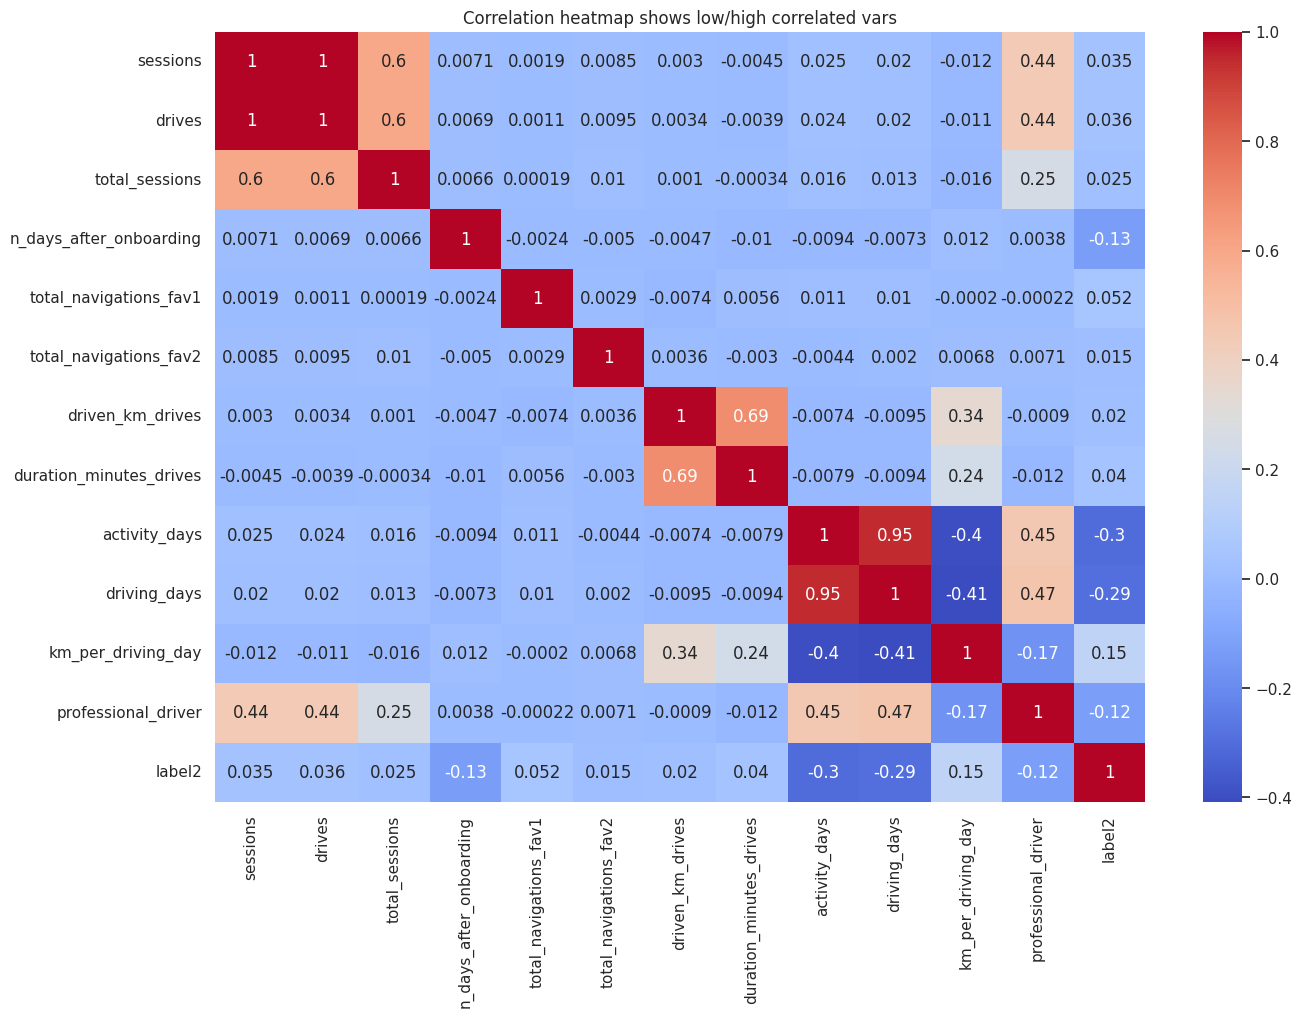

In [31]:
# 2. Plot correlation heatmap
sns.set_style("darkgrid")
sns.set_context("notebook")

plt.figure(figsize=(15,10))
sns.heatmap(df_corr.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap shows low/high correlated vars')
plt.show();

#### Model building

##### Assign predictor variables (X) and target (y)

- `X` will include all features excluding the target columns and the columns we decided to drop due to high multicollinearity.
- `y` will include the binary target column `label2` 


In [34]:
# Isolate predictor variables
X = df.drop(["label", "label2", "device", "device2", "sessions", "driving_days"], axis=1)

Now, isolate the dependent (target) variable. Assign it to a variable called `y`.

In [40]:
# Isolate target variable
y = df["label2"]

##### Split the data

Divide `X` into training and testing datasets.

In [42]:
# Perform the train-test split
trainX, testX, trainY, testY = train_test_split(X, y, stratify=y, random_state=42)

In [44]:
# Checking data
trainX.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0


##### Instantiate LR Model
Instantiate Logistic Regression model and fit it on training data.

In [55]:
# Set penalty to None since X is not scaled
logistic_model = LogisticRegression(penalty=None, max_iter=500).fit(trainX, trainY)

In [49]:
logistic_model.coef_

array([[ 1.91083909e-03,  3.28150041e-04, -4.06568817e-04,
         1.23057413e-03,  9.32579669e-04, -1.49326284e-05,
         1.09088527e-04, -1.06033608e-01,  1.82609704e-05,
        -1.52870661e-03]])

In [50]:
logistic_model.intercept_

array([-0.00170711])

#### Check final assumption

We will plot a regplot to verify the linear relationship between Features (X) and the logit of the Target variable (y).

In [53]:
# Get the predicted probabilities of the training data
# First col is prob of label2==0 (retained)
# 2nd col is prob of label2==1 (churned)
training_probabilities = logistic_model.predict_proba(trainX)
training_probabilities

array([[0.9396432 , 0.0603568 ],
       [0.6195027 , 0.3804973 ],
       [0.76473108, 0.23526892],
       ...,
       [0.91906683, 0.08093317],
       [0.85087325, 0.14912675],
       [0.93515221, 0.06484779]])

The log-odds formula, where _p_ is the prob of response:
- p -> prob of label2==1 (churned)
- 1-p -> prob of label2==0 (retained)
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$


In [57]:
# 1. Copy training data
logit_data = trainX.copy()

# 2. Create a new `logit` column 
logit_data['logit'] = [np.log(p[1] / p[0]) for p in training_probabilities]
logit_data.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,logit
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,-2.745227
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,-0.487438
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,-1.178795
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,-2.075275
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,-3.572710


Plot the data

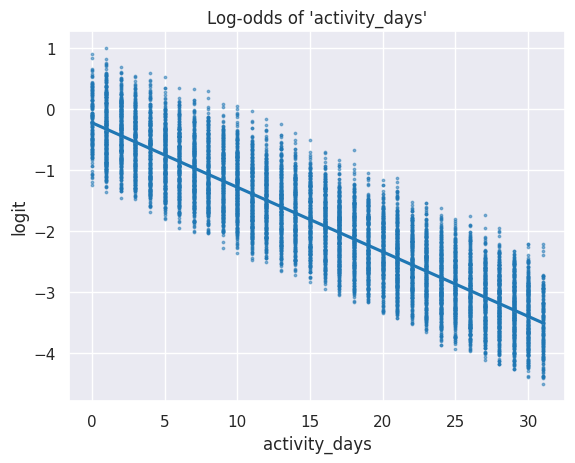

In [62]:
# Plot regplot of `activity_days` log-odds
sns.regplot(data=logit_data, x="activity_days", y="logit", scatter_kws={'s': 3, 'alpha': 0.5})
plt.title("Log-odds of 'activity_days'")
plt.show()

### 5. Results & Evaluation



In [63]:
# Generate predictions on test data
y_pred = logistic_model.predict(testX)

Get Test Score:

In [64]:
# Score the model (accuracy) on the test data
test_acc = logistic_model.score(testX, testY)
print("Acc = {0:.3f}%".format(test_acc*100))

Acc = 82.378%


#### Confusion Matrix

Create a confusion matrix using test data and predictions.

In [66]:
conf_matrix = confusion_matrix(testY, y_pred, labels=logistic_model.classes_)

Display the Matrix

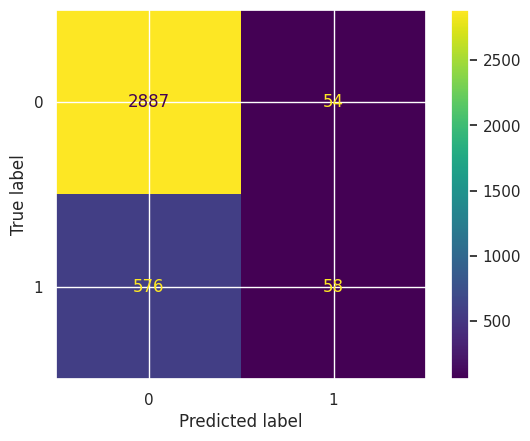

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_model.classes_)

disp.plot()
plt.show()

#### Metrics Calculations

The model's _precision_ is okay (~52%) but it's _recall_ is very low(<10%).  
Meaning it has a high amount of _false negative_ predictions, failing to capture users who will churn.

In [68]:
# Calculating precision manually
tn, fp, fn, tp = confusion_matrix(testY, y_pred, labels=logistic_model.classes_).ravel()

prec = tp/(tp+fp)
print("Precision = {0:.3f}%".format(prec*100))

Precision = 51.786%


In [69]:
# Calculating recall manually
recall = tp/(tp+fn)
print("Recall = {0:.3f}%".format(recall*100))

Recall = 9.148%


In [72]:
# Creating classification report
from sklearn.metrics import classification_report
report = classification_report(testY, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2941
           1       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



#### Visualizations


Visualizing the importance of the features:

In [93]:
# Create a list of (column_name, coefficient) tuples
logistic_coef = list(zip(trainX.columns, logistic_model.coef_[0]))
logistic_coef_df = pd.DataFrame(data=logistic_coef, columns=["feature", "importance"])
# Sort the list by coefficient value
from operator import itemgetter
logistic_coef = sorted(logistic_coef, key=itemgetter(1)) #logistic_coef.sort(key = lambda x: x[1])
print(logistic_coef)
logistic_coef_df.sort_values("importance", inplace=True)
logistic_coef_df

[('activity_days', -0.10603360764124033), ('professional_driver', -0.0015287066064979104), ('n_days_after_onboarding', -0.0004065688171806008), ('driven_km_drives', -1.4932628366365709e-05), ('km_per_driving_day', 1.8260970429688675e-05), ('duration_minutes_drives', 0.00010908852709236831), ('total_sessions', 0.00032815004083948574), ('total_navigations_fav2', 0.0009325796689877306), ('total_navigations_fav1', 0.0012305741340673942), ('drives', 0.0019108390901100027)]


,feature,importance
7,activity_days,-0.106034
9,professional_driver,-0.001529
2,n_days_after_onboarding,-0.000407
5,driven_km_drives,-0.000015
8,km_per_driving_day,0.000018
6,duration_minutes_drives,0.000109
1,total_sessions,0.000328
4,total_navigations_fav2,0.000933
3,total_navigations_fav1,0.001231
0,drives,0.001911


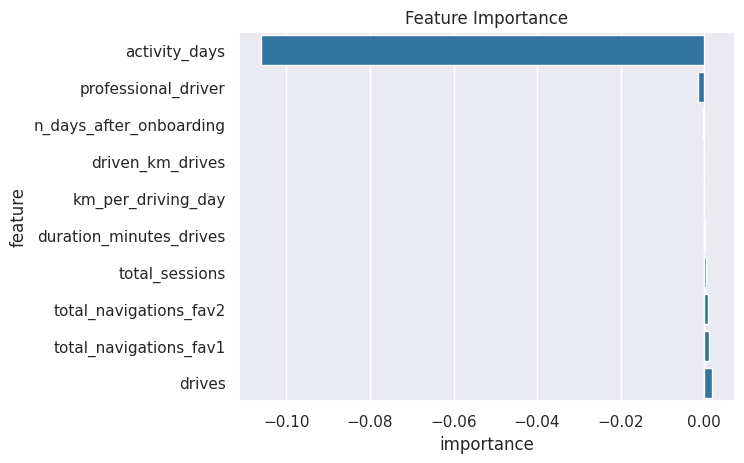

In [94]:
# Plot the feature importances
sns.barplot(data=logistic_coef_df, x="importance", y="feature", orient='h')
plt.title("Feature Importance")
plt.show()

### **Conclusion**


Overall the metrics of this model could be improved, specifically the recall score. At this point, the model results should not be trusted to make any business decisions but it can guide us in further iterations of the model.

We found that the model gave `activity_days` the highest importance among all other features. Since the engineered features had higher importance, it may be helpful to create more features to increase the model's scores.